/tmp/ipython-input-6-2888287017.py:24: RuntimeWarning: invalid value encountered in arccos
  theta2 = np.arccos((xi**2 + yi**2 - L1**2 - L2**2) / (2 * L1 * L2))  # Inverse Kinematics


Trajectory waypoints saved to 'trajectory_data2.csv'


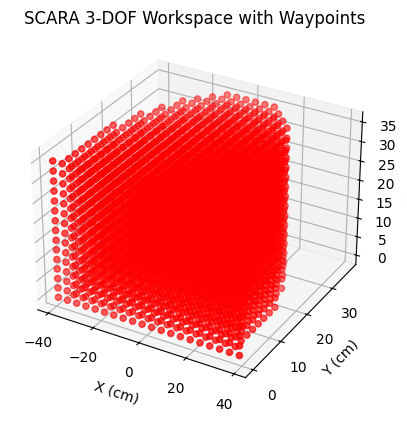

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SCARA 3-DOF parameters
L1 = 26  # Length of link 1 (in cm) #25.8
L2 = 13  # Length of link 2 (in cm) #12.5
d3_min, d3_max = 0, 35 # Range of vertical motion (prismatic joint, in cm) #34.5

# Step 1: Trajectory Waypoint Generation
# -----------------------------------------------------------
# Define a grid of Cartesian points within the workspace
x = np.linspace(-(L1 + L2), (L1 + L2), 20)  # X-coordinates (in cm)
y = np.linspace(0, (L1 + L2), 20)  # Y-coordinates (in cm)
z = np.linspace(d3_min, d3_max, 15)  # Z-coordinates (d3 range in cm)

# Generate a list of waypoints
waypoints = []
for xi in x:
    for yi in y:
        for zi in z:
            r = np.sqrt(xi**2 + yi**2)
            if r <= (L1 + L2):  # Check if point is within the reachable workspace
                theta2 = np.arccos((xi**2 + yi**2 - L1**2 - L2**2) / (2 * L1 * L2))  # Inverse Kinematics
                theta1 = np.arctan2(yi, xi) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))
                d3 = zi
                waypoints.append([xi, yi, zi, np.degrees(theta1), np.degrees(theta2), d3])  # Append to list

# Convert waypoints to a DataFrame
columns = ['X', 'Y', 'Z', 'Theta1', 'Theta2', 'd3']  # Column names
df = pd.DataFrame(waypoints, columns=columns)

# Step 2: Save the Waypoints to a CSV File
# -----------------------------------------------------------
output_file = 'trajectory_data2.csv'
df.to_csv(output_file, index=False)
print(f"Trajectory waypoints saved to '{output_file}'")

# Step 3: Visualization of Waypoints
# -----------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['X'], df['Y'], df['Z'], c='r', marker='o')  # Plot waypoints
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.set_title('SCARA 3-DOF Workspace with Waypoints')

plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import joblib  # For saving scalers

# Load waypoints data
waypoints_file = 'trajectory_data2.csv'
df = pd.read_csv(waypoints_file)

# Generate training data with normalized time step (t)
def generate_training_data_with_t(df, num_waypoints=100):  # Increased waypoints
    training_data = []
    for i in range(len(df) - 1):
        start = df.iloc[i][['X', 'Y', 'Z']].values
        target = df.iloc[i + 1][['X', 'Y', 'Z']].values

        # Generate intermediate waypoints with time step t
        for t in np.linspace(0, 1, num_waypoints):
            ideal_waypoint = start * (1 - t) + target * t
            deviation = np.random.normal(scale=0.01, size=3)  # Add small noise for realism
            waypoint = ideal_waypoint + deviation
            training_data.append(np.concatenate((start, target, [t], waypoint)))

    columns = ['X_start', 'Y_start', 'Z_start', 'X_target', 'Y_target', 'Z_target', 't', 'X', 'Y', 'Z']
    return pd.DataFrame(training_data, columns=columns)

# Generate training dataset
num_waypoints = 100
training_df = generate_training_data_with_t(df, num_waypoints)

# Add deviation columns
training_df['X_dev'] = training_df['X'] - training_df['X_start'] * (1 - training_df['t']) - training_df['X_target'] * training_df['t']
training_df['Y_dev'] = training_df['Y'] - training_df['Y_start'] * (1 - training_df['t']) - training_df['Y_target'] * training_df['t']
training_df['Z_dev'] = training_df['Z'] - training_df['Z_start'] * (1 - training_df['t']) - training_df['Z_target'] * training_df['t']

# Split data into inputs (start + target + t) and outputs (deviations)
input_features = training_df[['X_start', 'Y_start', 'Z_start', 'X_target', 'Y_target', 'Z_target', 't']].values
target_outputs = training_df[['X_dev', 'Y_dev', 'Z_dev']].values

# Normalize data
scaler_input = MinMaxScaler(feature_range=(0, 1))
scaler_output = MinMaxScaler(feature_range=(0, 1))

input_features_normalized = scaler_input.fit_transform(input_features)
target_outputs_normalized = scaler_output.fit_transform(target_outputs)

# Save scalers for later use
joblib.dump(scaler_input, 'scaler_input2.pkl')
joblib.dump(scaler_output, 'scaler_output2.pkl')
print("Scalers saved successfully.")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features_normalized, target_outputs_normalized, test_size=0.2, random_state=42
)

# Build the neural network
model = Sequential([
    Dense(256, activation='relu', input_shape=(7,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(3, activation='linear')  # Predict deviations
])

# Custom loss function
import tensorflow as tf
import tensorflow.keras.backend as K

# Define weights as a TensorFlow constant
weights = tf.constant([1.0, 1.0, 2.0], dtype=tf.float32)  # Emphasize Z deviation

# Custom loss function
def weighted_loss(y_true, y_pred):
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_loss, metrics=[RootMeanSquaredError()])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)

# Evaluate the model
loss, rmse = model.evaluate(X_test, y_test)
print(f"Test RMSE: {rmse:.4f}")

# Save the model to a file
model.save('trajectory_model2.h5')
print("Model saved as trajectory_model2.h5")

Scalers saved successfully.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4859/4859 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0259 - root_mean_squared_error: 0.1127 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1066
Epoch 2/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - loss: 0.0227 - root_mean_squared_error: 0.1061 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1066
Epoch 3/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.0227 - root_mean_squared_error: 0.1060 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1064
Epoch 4/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 0.0228 - root_mean_squared_error: 0.1061 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1067
Epoch 5/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 0.0227 - root_mean_squared_error: 0.1060 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1066
Epoch 6/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - loss: 0.0227 - root_mean_squared_error: 0.1059 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1064
Epoch 7/30
4859/4859 ━━━━━━━━━━━━━━━━━━━━ 38s

Test RMSE: 0.1056
Model saved as trajectory_model2.h5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import joblib  # For saving and loading scalers
import tensorflow as tf

# Define custom loss function
weights = tf.constant([1.0, 1.0, 2.0], dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.square((y_pred - y_true) * weights), axis=-1)

# Step 1: Load the saved model
model = load_model('trajectory_model2.h5', custom_objects={'weighted_loss': weighted_loss})
print("Model loaded successfully.")

# Step 2: Load the scalers used during training
try:
    scaler_input = joblib.load('scaler_input2.pkl')
    scaler_output = joblib.load('scaler_output2.pkl')
    print("Scalers loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("Scalers were not found. Ensure you save the scalers during training.")

Model loaded successfully.
Scalers loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━

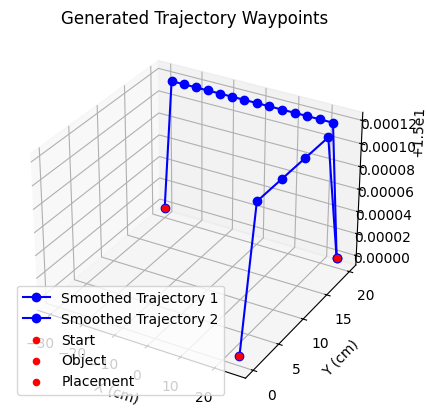

Start to Object Waypoints:
[X,           Y,           Z]
[[25.          0.         15.        ]
 [24.99985523  2.90953753 15.00011832]
 [24.99985523  7.63681025 15.00011832]
 [24.99985523 12.36408298 15.00011832]
 [24.99985523 17.09135571 15.00011832]
 [25.         20.         15.        ]]
Object to Placement Waypoints 2:
[X,           Y,           Z]
[[ 25.          20.          15.        ]
 [ 22.34737296  20.00044662  15.00011832]
 [ 18.52467792  20.00044662  15.00011832]
 [ 14.70198288  20.00044662  15.00011832]
 [ 10.87928785  20.00044662  15.00011832]
 [  7.05659281  20.00044662  15.00011832]
 [  3.23389778  20.00044662  15.00011832]
 [ -0.58879726  20.00044662  15.00011832]
 [ -4.41149229  20.00044662  15.00011832]
 [ -8.23418733  20.00044662  15.00011832]
 [-12.05688236  20.00044662  15.00011832]
 [-15.8795774   20.00044662  15.00011832]
 [-19.70227243  20.00044662  15.00011832]
 [-23.52496747  20.00044662  15.00011832]
 [-27.34766251  20.00044662  15.00011832]
 [-30.         

In [ ]:
# Step 3: Prediction function
def predict_trajectory_with_t_fixed(start, target, num_waypoints=30):
    """
    Predict trajectory waypoints between start and target points with a fixed progression.

    Args:
        start (array): Starting point (X, Y, Z).
        target (array): Target point (X, Y, Z).
        num_waypoints (int): Number of waypoints to generate.

    Returns:
        np.array: Predicted waypoints including start and target points.
    """
    waypoints = [start]  # Include the start point explicitly
    for t in np.linspace(0, 1, num_waypoints):
        # Prepare input with normalized t values
        ideal_waypoint = start * (1 - t) + target * t
        input_data = np.concatenate((start, target, [t])).reshape(1, -1)
        normalized_input = scaler_input.transform(input_data)  # Scale input features

        # Predict deviation
        predicted_deviation_normalized = model.predict(normalized_input)
        predicted_deviation = scaler_output.inverse_transform(predicted_deviation_normalized)  # Unscale output

        # Add deviation to ideal waypoint
        waypoint = ideal_waypoint + predicted_deviation.flatten()
        waypoints.append(waypoint)

    waypoints.append(target)  # Include the target point explicitly
    return np.array(waypoints)

# Step 4: Smooth the predicted waypoints
def uniform_waypoints(waypoints, num_points):
    t_original = np.linspace(0, 1, len(waypoints))
    t_uniform = np.linspace(0, 1, num_points)
    interpolated_waypoints = interp1d(t_original, waypoints, axis=0)(t_uniform)
    return interpolated_waypoints

# Step 5: Test the prediction function
start_point = np.array([25, 0, 15])  # Example start point
target_point = np.array([25, 20, 15])  # Example target point
target_point2 = np.array([-30, 20, 15])  # Example target point

snwp = 16 # Smoothed waypoints number, actual waypoints
nwp = snwp * 3 # Predicted waypoints number

predicted_waypoints_fixed = predict_trajectory_with_t_fixed(start_point, target_point, num_waypoints=12)
smoothed_waypoints = uniform_waypoints(predicted_waypoints_fixed, 6)

predicted_waypoints_fixed2 = predict_trajectory_with_t_fixed(target_point, target_point2, num_waypoints=nwp)
smoothed_waypoints2 = uniform_waypoints(predicted_waypoints_fixed2, snwp)

# Step 6: Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(smoothed_waypoints[:, 0], smoothed_waypoints[:, 1], smoothed_waypoints[:, 2], c='b', marker='o', label='Smoothed Trajectory 1')
ax.plot(smoothed_waypoints2[:, 0], smoothed_waypoints2[:, 1], smoothed_waypoints2[:, 2], c='b', marker='o', label='Smoothed Trajectory 2')

ax.scatter(start_point[0], start_point[1], start_point[2], c='r', label='Start', marker='o')
ax.scatter(target_point[0], target_point[1], target_point[2], c='r', label='Object', marker='o')
ax.scatter(target_point2[0], target_point2[1], target_point2[2], c='r', label='Placement', marker='o')

ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_title('Generated Trajectory Waypoints')
ax.legend()
plt.show()

# Step 7: Print smoothed waypoints for debugging
print("Start to Object Waypoints:")
print("[X,           Y,           Z]")
print(smoothed_waypoints)
print("Object to Placement Waypoints 2:")
print("[X,           Y,           Z]")
print(smoothed_waypoints2)
print(type(smoothed_waypoints))
